In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GOOGLE_MODEL_NAME = os.getenv("GOOGLE_MODEL_NAME", "gemini-pro") 

from langchain_google_genai import ChatGoogleGenerativeAI

c:\CentennialCode\AI-Tutor-agentic-rag\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, ChatMessage



### Load document content

In [14]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

def load_document_content(file_path):
    try:
        # Load documents from the file using TextLoader
        loader = TextLoader(file_path)
        documents = loader.load()

        # Split text into smaller chunks
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        docs = text_splitter.split_documents(documents)

        # Concatenate the chunks into a single context string
        context = "\n".join([doc.page_content for doc in docs])
        return context
    except Exception as e:
        return f"Error loading document content: {e}"

file_name = 'topic_material.txt'
file_path = os.path.join("data", file_name)
context = load_document_content(file_path)



In [38]:
context

'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may define a generic behavior, and then\nredefine it for more specialized entities that 

In [4]:
SUMMARY_PROMPT = """
Create a summary of the topics included in the context.
context: {context}
"""

GREETING_PROMPT = """
You are an AI Tutor. You are given a topic and a subject.
You need to create a greeting message for the student,
asking them what they want to learn based on the subject, topic and content summary.
Keep the greeting short and concise.

Subject: {subject}
Topic: {topic}
Content summary of the topic: {summary}
"""

QUESTION_GUARDING_PROMPT = """
You are an AI Tutor. Based on the content summary of the topic, 
you need to decide if the student's question is related to the content summary.
For educational purpose, it is ok to be related but not exactly the same topic.
If it is, respond "Pass".  
If it is not, respond "Fail" 

Student Question: {question}
Content summary of the topic: {summary}
"""

QUESTION_ANSWERING_PROMPT = """
You are an AI Tutor. You are given a question and a topic.
You need to answer the question based on the context.
After finishing explaining, ask the student a question to check their understanding.

Question: {question}
Context: {context}
"""

check_question_answer_prompt = """
You are an AI Tutor. Follow the question and answer, and the context,
Check if the student's answer is correct.
If it is, respond "Correct". If it is not, respond "Wrong".

question_answer_context: {question_answer_context}
Context: {context}
"""


hints_prompt = """
You are an AI Tutor. Based on the question and student's answer, 
understand the student's misconcept and provide hints to the student to help them answer the question.

Question Answer context: {question_answer_context}
"""


intermediate_summary_prompt = """
You are an AI Tutor. Based on all the previous conversations with student, create a summary of the session.
Focus on the key concepts and ideas that the student has learnt.
At the end of the summary, ask the student if there any other questions.

Question Answer context: {question_answer_context}
"""

any_further_question_prompt = """
Based on the student's answer, determine if the student has any further questions.
If the student has any further questions, respond "Yes". If not, respond "No".

Student Answer: {student_answer}
"""

explain_answer_prompt = """
You are an AI Tutor. Based on the question and student's answer, 
explain the correct answer to the student. 
Keep the explanation short and concise. 
Forcus on the key concepts and ideas based on student's wrong answer.

Question Answer context: {question_answer_context}
"""


session_summary_prompt = """
You are an AI Tutor. Based on all the previous conversations with student, create a concise summary of the session.
Focus on the key concepts and ideas that the student has learnt.

Messages: {messages}
"""



In [125]:
from typing import TypedDict, Annotated
from datetime import timedelta,datetime
from langgraph.graph.message import add_messages


llm = ChatGoogleGenerativeAI(model="gemini-pro")

class AgentState(TypedDict):
    subject: str
    topic: str
    context: str
    summary: str
    messages: Annotated[list, add_messages]
    answer_trials: int
    start_time: datetime
    duration_minutes: int
    # time_out: bool

     
def create_summary(state: AgentState):
    response = llm.invoke(SUMMARY_PROMPT.format(context=state["context"]))
    return {"summary": response.content}

def greeting(state: AgentState):
    subject = state["subject"]
    topic = state["topic"]
    messages = state["messages"]
    summary = state["summary"]

    greeting_prompt = GREETING_PROMPT.format(subject=subject, topic=topic, summary=summary)
    messages= [HumanMessage(content=greeting_prompt.format(subject=subject, topic=topic))]
    response = llm.invoke(messages)
    return {"messages": response}

def student_input(state:AgentState):
    # print(state["messages"][-1].content)
    return state

#helper function
def time_out(state:AgentState):
    current_time = datetime.now()
    start_time = state["start_time"]
    duration_minutes = state["duration_minutes"]    
    return (current_time - start_time) > timedelta(minutes=duration_minutes)

def question_guarding(state:AgentState):
    if time_out(state):
        return "TimeOut"    
    question = state["messages"][-1].content
    summary = state["summary"]
    response = llm.invoke(QUESTION_GUARDING_PROMPT.format(question=question, summary=summary))
    content = response.content
    if content.startswith("Pass"):
        return "Pass"
    else:
        return "Fail"

def reask_question(state:AgentState):
    return {"messages": [AIMessage(content="Your question is not related to the topic. Please ask a question related to the topic.")]}


def llm_answer_question(state:AgentState):
    # print("Answer the question: ", state["messages"][-1].content)
    question = state["messages"][-1].content
    response = llm.invoke(QUESTION_ANSWERING_PROMPT.format(question=question, context = context))
    result=response.content
    return {"messages": [AIMessage(content=result)]}

def student_answer_question(state:AgentState):
    # print(state["messages"][-1].content)
    return state

#helper function
def get_question_answer_context(state:AgentState):
    answer_trials = state["answer_trials"]
    number_of_related_messages = (answer_trials+1)*2
    question_answer_context = state["messages"][-number_of_related_messages:]
    print(f"number_of_related_messages: {number_of_related_messages}")
    print(f"question_answer_context for get_question_answer_context: {question_answer_context}")
    return question_answer_context

#TODO: need further verify if anwser_trials is correct
def further_question_correctness(state:AgentState, max_trials=3):
    if time_out(state):
        return "TimeOut"
    answer_trials = state["answer_trials"]
    if answer_trials >= max_trials:
        return "Stop"
    question_answer_context = get_question_answer_context(state)
    response = llm.invoke(check_question_answer_prompt.format(question_answer_context=question_answer_context, context=context))
    result = response.content
    if result.startswith("Yes"):
        return "Yes"
    else:
        return "No"
    #need to add one trials for answer_trials

def add_wrong_answer_trials(state:AgentState):
    return {"answer_trials": state["answer_trials"] + 1}

def hints(state:AgentState):
    question_answer_context = get_question_answer_context(state)
    response = llm.invoke(hints_prompt.format(question_answer_context=question_answer_context))
    result = response.content
    return {"messages": [AIMessage(content=result)]}

def explain_answer(state:AgentState):
    question_answer_context = get_question_answer_context(state)
    response = llm.invoke(explain_answer_prompt.format(question_answer_context=question_answer_context))
    result = response.content
    return {"messages": [AIMessage(content=result)]}

def intermediate_summary(state:AgentState):
    question_answer_context = get_question_answer_context(state)
    response = llm.invoke(intermediate_summary_prompt.format(question_answer_context=question_answer_context))
    result = response.content
    return {"messages": [AIMessage(content=result)]}

def student_answer_if_any_further_question(state:AgentState):
    return state

def any_further_question(state:AgentState):
    if time_out(state):
        return "TimeOut"
    student_answer = state["messages"][-1].content
    response = llm.invoke(any_further_question_prompt.format(student_answer=student_answer))
    result = response.content
    if result.startswith("Yes"):
        return "Yes"
    else:
        return "No"
    
def time_out_message(state:AgentState):
    return {"messages": [AIMessage(content="Time is up. We will summarize the session now.")]}

def session_summary(state:AgentState):
    messages = state["messages"]
    response = llm.invoke(session_summary_prompt.format(messages=messages))
    result = response.content
    return {"messages": [AIMessage(content=result)]}

def ask_new_question(state:AgentState):
    return {"messages": [HumanMessage(content="What is your next question?")]}


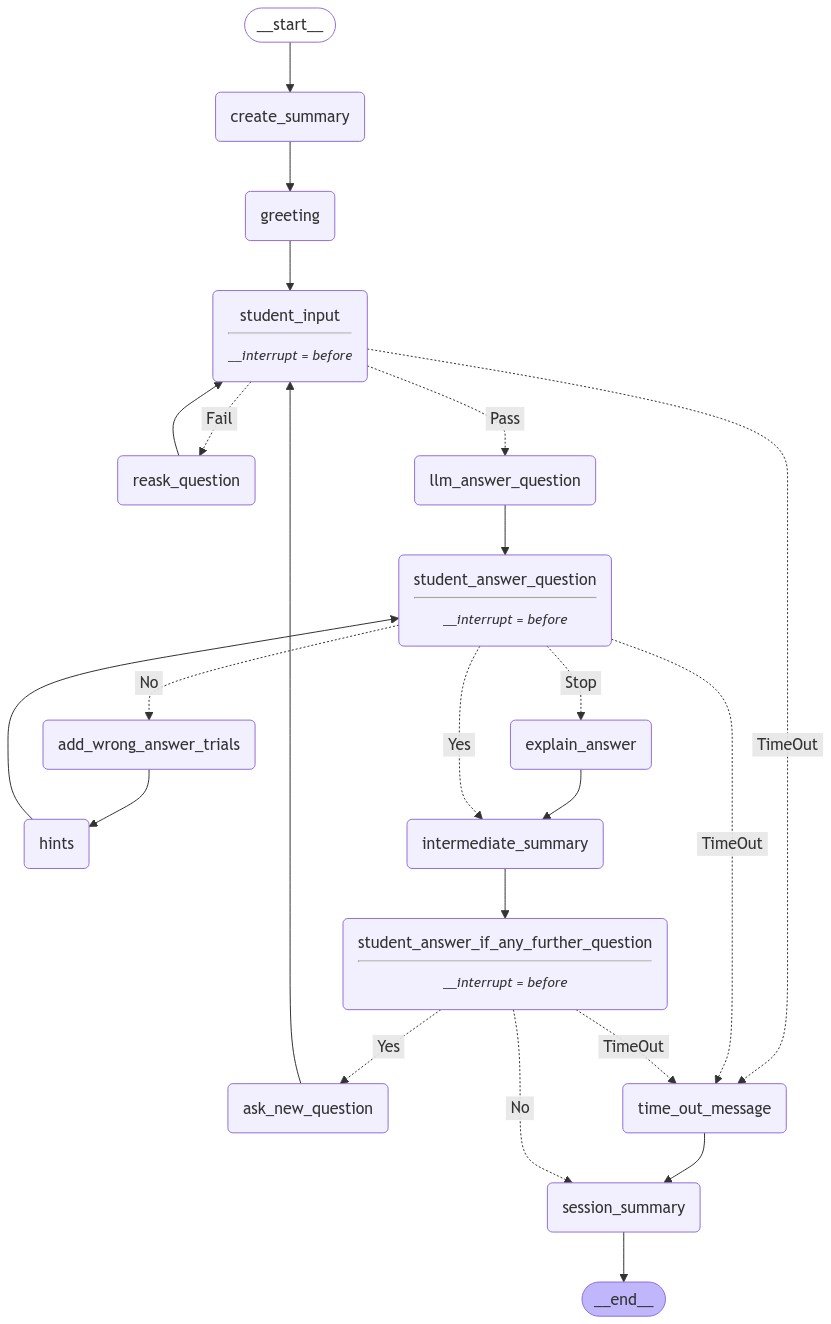

In [126]:
from langgraph.graph import START,END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("create_summary", create_summary)
workflow.add_node("greeting", greeting)
workflow.add_node("student_input", student_input)
workflow.add_node("reask_question", reask_question)
workflow.add_node("llm_answer_question", llm_answer_question)
workflow.add_node("student_answer_question", student_answer_question)
workflow.add_node("add_wrong_answer_trials", add_wrong_answer_trials)
workflow.add_node("hints", hints)
workflow.add_node("explain_answer", explain_answer)
workflow.add_node("intermediate_summary", intermediate_summary)
workflow.add_node("student_answer_if_any_further_question", student_answer_if_any_further_question)
workflow.add_node("session_summary", session_summary)
workflow.add_node("ask_new_question", ask_new_question)
workflow.add_node("time_out_message", time_out_message)

# further_question_correctness)
workflow.add_edge(START, "create_summary")
workflow.add_edge("create_summary", "greeting")
workflow.add_edge("greeting", "student_input")
workflow.add_edge("reask_question", "student_input")

workflow.add_conditional_edges(
    "student_input",
    question_guarding,
    {
        "TimeOut": "time_out_message",
        "Pass": "llm_answer_question",
        "Fail": "reask_question"
    }
)

workflow.add_edge("llm_answer_question", "student_answer_question")

workflow.add_conditional_edges(
    "student_answer_question",
    further_question_correctness,
    {
        "TimeOut": "time_out_message",
        "Yes": "intermediate_summary",
        "No": "add_wrong_answer_trials",
        "Stop": "explain_answer"
    }
)

workflow.add_edge("add_wrong_answer_trials", "hints")
workflow.add_edge("hints", "student_answer_question")
workflow.add_edge("explain_answer", "intermediate_summary")
workflow.add_edge("intermediate_summary", "student_answer_if_any_further_question")

workflow.add_conditional_edges(
    "student_answer_if_any_further_question",
    any_further_question,
    {
        "TimeOut": "time_out_message",
        "Yes": "ask_new_question",
        "No": "session_summary"
    }
)

workflow.add_edge("time_out_message", "session_summary")
workflow.add_edge("ask_new_question", "student_input")
workflow.add_edge("session_summary", END)

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
app = workflow.compile(checkpointer=memory, interrupt_before=["student_input", "student_answer_question", "student_answer_if_any_further_question"])

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


### Simple run for question answering


In [60]:
# Input
initial_input = {"subject":"Java", "topic": "Polymorphism in Java"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in app.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': []}
{'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': [AIMessage(content="Hello there! Welcome to my Java tutoring session on Polymorphism. I'm here to help you understand the concept of polymorphism in Java. What specific areas of polymorphism would you like to learn about today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-80d48234-5f0a-40f6-8de8-d7d70a188903-0', usage_metadata={'input_tokens': 63, 'output_tokens': 41, 'total_tok

In [61]:
user_input = "what is python decorator?"

# We now update the state as if we are the student_input node
app.update_state(thread, {"messages": HumanMessage(content=user_input)}, as_node="student_input")

# We can check the state
print("--State after update--")
print(app.get_state(thread))
print("--Next node=-")
print(app.get_state(thread).next)
print("--Node values--")
print(app.get_state(thread).values)
print("--Messages--")
for message in app.get_state(thread).values["messages"]:
    message.pretty_print()


Question guarding:  what is python decorator?
Fail
--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': [AIMessage(content="Hello there! Welcome to my Java tutoring session on Polymorphism. I'm here to help you understand the concept of polymorphism in Java. What specific areas of polymorphism would you like to learn about today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-80d48234-5f0a-40f6-8de8-d7d70a188903-0', usage_metadata={'input_tokens': 63, 'outp

In [62]:
for event in app.stream(None, thread, stream_mode="values"):
    # print(event)
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is python decorator?
================================== Ai Message ==================================

Your question is not related to the topic. Please ask a question related to the topic.


In [63]:
# Get user input
# try:
#     user_input = input("Ask question:")
# except:
user_input = "what is Polymorphism?"

# We now update the state as if we are the student_input node
app.update_state(thread, {"messages": HumanMessage(content=user_input)}, as_node="student_input")

# We can check the state
print("--State after update--")
print(app.get_state(thread))
print("--Next node=-")
print(app.get_state(thread).next)
print("--Node values--")
print(app.get_state(thread).values)
print("--Messages--")
for message in app.get_state(thread).values["messages"]:
    message.pretty_print()


Question guarding:  what is Polymorphism?
Pass
--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': [AIMessage(content="Hello there! Welcome to my Java tutoring session on Polymorphism. I'm here to help you understand the concept of polymorphism in Java. What specific areas of polymorphism would you like to learn about today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-80d48234-5f0a-40f6-8de8-d7d70a188903-0', usage_metadata={'input_tokens': 63, 'output_t

In [64]:
for event in app.stream(None, thread, stream_mode="values"):
    # print(event)
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is Polymorphism?
================================== Ai Message ==================================

**Definition of Polymorphism**

Polymorphism is a concept in object-oriented programming that allows different classes to have methods with the same name, but with different implementations. This allows objects of different classes to respond to the same message in different ways.

In the example of the CommissionEmployee and BasePlusCommisionEmployee classes, the toString() method behaves differently when applied to different objects because each class has its own implementation of the method.

**Understanding Polymorphism**

To understand polymorphism, consider the following scenario:

You have a class called "Shape" that represents the abstract concept of a geometric shape. You then create subclasses of Shape, such as "Circle" and "Rectangle". Each subclass inherits the properties and methods of the 

## New question answering flow

In [114]:
def human_input(app, thread, user_input, node):
    app.update_state(thread, {"messages": HumanMessage(content=user_input)}, as_node=node)

    # We can check the state
    print("--State after update--")
    print(app.get_state(thread))
    print("--Next node=-")
    print(app.get_state(thread).next)
    print("--Node values--")
    print(app.get_state(thread).values)
    print("--Messages--")
    for message in app.get_state(thread).values["messages"]:
        message.pretty_print()

def run_graph(app, thread):
    for event in app.stream(None, thread, stream_mode="values"):
        # print(event)
        event["messages"][-1].pretty_print()
        
    # Get the current state
    current_state = app.get_state(thread)
    print("--Current Node--")
    print(current_state.next)  # This will show the next node to be executed


In [127]:
# Input
initial_input = {"subject":"Java", "topic": "Polymorphism in Java", "context":context, "summary": "", "messages": [], "answer_trials": 0, "start_time": datetime.now(), "duration_minutes": 30}

# Thread
thread = {"configurable": {"thread_id": "1"}}



# Run the graph until the first interruption
for event in app.stream(initial_input, thread, stream_mode="values"):
    print(event)


{'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may define a generic beh

In [128]:
for message in app.get_state(thread).values["messages"]:
    message.pretty_print()

================================== Ai Message ==================================

Hi there! Welcome to your Java session on Polymorphism. Today, we'll explore how objects of different types can interact with each other without knowing their specific class. We'll cover abstract classes, interfaces, and examples of polymorphism in Java. What specific area of polymorphism would you like to learn more about?


In [113]:
app.get_state(thread).values


{'subject': 'Java',
 'topic': 'Polymorphism in Java',
 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may define a generic b

In [129]:
human_input(app, thread, user_input="what is python decorator?", node="student_input")


--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for

In [130]:
run_graph(app, thread)

================================ Human Message =================================

what is python decorator?
================================== Ai Message ==================================

Your question is not related to the topic. Please ask a question related to the topic.
--Current Node--
('student_input',)


In [131]:
human_input(app, thread, user_input="what is Interfaces?", node="student_input")

--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for

In [132]:
run_graph(app, thread)

================================ Human Message =================================

what is Interfaces?
================================== Ai Message ==================================

**Answer:**

Interfaces in Java are a powerful feature that allows you to define a contract for a set of methods without providing any implementation. They are useful for:

* Capturing similarities between unrelated classes without forcing a class relationship.
* Declaring methods that one or more classes are expected to implement.
* Revealing an object's programming interface without revealing its class.

**Question for you:**

Can you provide an example of how you might use an interface in your own Java code?
--Current Node--
('student_answer_question',)


In [133]:
app.get_state(thread).values["messages"][-2:]


[HumanMessage(content='what is Interfaces?', additional_kwargs={}, response_metadata={}, id='9c85885e-5e8e-4f82-9289-a0f6a3d8efe3'),
 AIMessage(content="**Answer:**\n\nInterfaces in Java are a powerful feature that allows you to define a contract for a set of methods without providing any implementation. They are useful for:\n\n* Capturing similarities between unrelated classes without forcing a class relationship.\n* Declaring methods that one or more classes are expected to implement.\n* Revealing an object's programming interface without revealing its class.\n\n**Question for you:**\n\nCan you provide an example of how you might use an interface in your own Java code?", additional_kwargs={}, response_metadata={}, id='2258fd61-9481-4d8b-9bd5-70dbbde3ed69')]

In [134]:
human_input(app, thread, user_input="Interface is used to create child class?", node="student_answer_question")

number_of_related_messages: 2
question_answer_context for get_question_answer_context: [AIMessage(content="**Answer:**\n\nInterfaces in Java are a powerful feature that allows you to define a contract for a set of methods without providing any implementation. They are useful for:\n\n* Capturing similarities between unrelated classes without forcing a class relationship.\n* Declaring methods that one or more classes are expected to implement.\n* Revealing an object's programming interface without revealing its class.\n\n**Question for you:**\n\nCan you provide an example of how you might use an interface in your own Java code?", additional_kwargs={}, response_metadata={}, id='2258fd61-9481-4d8b-9bd5-70dbbde3ed69'), HumanMessage(content='Interface is used to create child class?', additional_kwargs={}, response_metadata={}, id='cfb9fa60-8792-4ab1-b89a-be8bc9ef04c0')]
--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymor

In [135]:
run_graph(app, thread)

================================ Human Message =================================

Interface is used to create child class?
================================ Human Message =================================

Interface is used to create child class?
number_of_related_messages: 4
question_answer_context for get_question_answer_context: [AIMessage(content='Your question is not related to the topic. Please ask a question related to the topic.', additional_kwargs={}, response_metadata={}, id='5dcd6362-ea17-4923-be28-67408e83f3ae'), HumanMessage(content='what is Interfaces?', additional_kwargs={}, response_metadata={}, id='9c85885e-5e8e-4f82-9289-a0f6a3d8efe3'), AIMessage(content="**Answer:**\n\nInterfaces in Java are a powerful feature that allows you to define a contract for a set of methods without providing any implementation. They are useful for:\n\n* Capturing similarities between unrelated classes without forcing a class relationship.\n* Declaring methods that one or more classes are exp

In [136]:
app.get_state(thread).values


{'subject': 'Java',
 'topic': 'Polymorphism in Java',
 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may define a generic b

In [137]:
human_input(app, thread, user_input="Interface can make sure that all classes implement the same method from the interface?", node="student_answer_question")


number_of_related_messages: 4
question_answer_context for get_question_answer_context: [AIMessage(content="**Answer:**\n\nInterfaces in Java are a powerful feature that allows you to define a contract for a set of methods without providing any implementation. They are useful for:\n\n* Capturing similarities between unrelated classes without forcing a class relationship.\n* Declaring methods that one or more classes are expected to implement.\n* Revealing an object's programming interface without revealing its class.\n\n**Question for you:**\n\nCan you provide an example of how you might use an interface in your own Java code?", additional_kwargs={}, response_metadata={}, id='2258fd61-9481-4d8b-9bd5-70dbbde3ed69'), HumanMessage(content='Interface is used to create child class?', additional_kwargs={}, response_metadata={}, id='cfb9fa60-8792-4ab1-b89a-be8bc9ef04c0'), AIMessage(content='**Misconception:** The student seems to believe that interfaces are used to create child classes.\n\n**H

In [123]:
run_graph(app, thread)


================================ Human Message =================================

Interface can make sure that all classes implement the same method from the interface?
================================ Human Message =================================

Interface can make sure that all classes implement the same method from the interface?
================================== Ai Message ==================================

**Misconception:** The student seems to think that interfaces are used to create child classes.

**Hint:** Interfaces are not used to create child classes. Instead, they define a contract that classes must implement.
--Current Node--
('student_answer_question',)


In [124]:
app.get_state(thread).values

{'subject': 'Java',
 'topic': 'Polymorphism in Java',
 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may define a generic b

In [106]:
human_input(app, thread, user_input="Interface do not have any implementation, Abstract classes provide a partial implementation", node="student_answer_question")


--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for

In [107]:
run_graph(app, thread)

================================ Human Message =================================

Interface do not have any implementation, Abstract classes provide a partial implementation
================================== Ai Message ==================================

**Misconception:** The student seems to be confused about the concept of interfaces and abstract classes. They believe that an interface has implementation, which is not the case.

**Hints:**

* An interface is a contract that defines a set of methods that a class must implement. It does not contain any implementation, and it cannot be instantiated.
* An abstract class is a class that contains abstract methods (methods without implementation). It can be instantiated, but it cannot be used directly.
* The purpose of an interface is to enforce a certain behavior on a class, while the purpose of an abstract class is to provide a common base for a group of related classes.
--Current Node--
('student_answer_question',)


In [138]:
app.get_state(thread).values


{'subject': 'Java',
 'topic': 'Polymorphism in Java',
 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may define a generic b

In [139]:
human_input(app, thread, user_input="when both dog and cat are child of animal class, but both of them have to bark?", node="student_answer_question")


number_of_related_messages: 4
question_answer_context for get_question_answer_context: [HumanMessage(content='Interface is used to create child class?', additional_kwargs={}, response_metadata={}, id='cfb9fa60-8792-4ab1-b89a-be8bc9ef04c0'), AIMessage(content='**Misconception:** The student seems to believe that interfaces are used to create child classes.\n\n**Hint:** Interfaces define a contract that classes must implement, but they do not create child classes.', additional_kwargs={}, response_metadata={}, id='62029d2c-ea41-4869-ba6d-a98e2aeb785e'), HumanMessage(content='Interface can make sure that all classes implement the same method from the interface?', additional_kwargs={}, response_metadata={}, id='086af796-0fc8-4108-a0c1-3d7c2483f673'), HumanMessage(content='when both dog and cat are child of animal class, but both of them have to bark?', additional_kwargs={}, response_metadata={}, id='f1af1e11-67b7-48a9-be10-8afe186a912a')]
--State after update--
StateSnapshot(values={'subjec

In [140]:
run_graph(app, thread)

================================ Human Message =================================

when both dog and cat are child of animal class, but both of them have to bark?
================================ Human Message =================================

when both dog and cat are child of animal class, but both of them have to bark?
number_of_related_messages: 6
question_answer_context for get_question_answer_context: [HumanMessage(content='what is Interfaces?', additional_kwargs={}, response_metadata={}, id='9c85885e-5e8e-4f82-9289-a0f6a3d8efe3'), AIMessage(content="**Answer:**\n\nInterfaces in Java are a powerful feature that allows you to define a contract for a set of methods without providing any implementation. They are useful for:\n\n* Capturing similarities between unrelated classes without forcing a class relationship.\n* Declaring methods that one or more classes are expected to implement.\n* Revealing an object's programming interface without revealing its class.\n\n**Question for you:

In [141]:
human_input(app, thread, user_input="a Drawable interface, implements it in a Circle class, and then uses it in the Main class. The interface allows for polymorphism, where different shapes could be treated uniformly as long as they implement the Drawable interface.", node="student_answer_question")


number_of_related_messages: 6
question_answer_context for get_question_answer_context: [HumanMessage(content='Interface is used to create child class?', additional_kwargs={}, response_metadata={}, id='cfb9fa60-8792-4ab1-b89a-be8bc9ef04c0'), AIMessage(content='**Misconception:** The student seems to believe that interfaces are used to create child classes.\n\n**Hint:** Interfaces define a contract that classes must implement, but they do not create child classes.', additional_kwargs={}, response_metadata={}, id='62029d2c-ea41-4869-ba6d-a98e2aeb785e'), HumanMessage(content='Interface can make sure that all classes implement the same method from the interface?', additional_kwargs={}, response_metadata={}, id='086af796-0fc8-4108-a0c1-3d7c2483f673'), HumanMessage(content='when both dog and cat are child of animal class, but both of them have to bark?', additional_kwargs={}, response_metadata={}, id='f1af1e11-67b7-48a9-be10-8afe186a912a'), AIMessage(content='**Misconception:** The student se

In [142]:
run_graph(app, thread)

================================ Human Message =================================

a Drawable interface, implements it in a Circle class, and then uses it in the Main class. The interface allows for polymorphism, where different shapes could be treated uniformly as long as they implement the Drawable interface.
================================ Human Message =================================

a Drawable interface, implements it in a Circle class, and then uses it in the Main class. The interface allows for polymorphism, where different shapes could be treated uniformly as long as they implement the Drawable interface.
number_of_related_messages: 8
question_answer_context for get_question_answer_context: [HumanMessage(content='what is Interfaces?', additional_kwargs={}, response_metadata={}, id='9c85885e-5e8e-4f82-9289-a0f6a3d8efe3'), AIMessage(content="**Answer:**\n\nInterfaces in Java are a powerful feature that allows you to define a contract for a set of methods without providing any 

In [143]:
human_input(app, thread, user_input="testing", node="student_answer_question")


--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for

In [145]:
run_graph(app, thread)

================================== Ai Message ==================================

**Summary of the Session**

**Key Concepts and Ideas:**

* Polymorphism allows objects of different types to interact with each other without knowing their specific class.
* Interfaces are contracts that define methods that classes must implement.
* Interfaces do not create child classes.
* Interfaces enable polymorphism, allowing different classes to be treated uniformly if they implement the same interface.

**Additional Questions:**

* Are there any other questions you have about interfaces or object-oriented programming?
--Current Node--
()


## testing

In [ ]:
app.get_state(thread)

StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may

In [ ]:
app.get_state(thread).next

('student_answer_question',)

In [ ]:
app.get_state(thread).config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef91d03-c8a0-6c58-8006-790073c226b1'}}

In [ ]:
app.get_state(thread).metadata

{'source': 'loop',
 'writes': {'llm_answer_question': {'messages': [AIMessage(content='**Answer:**\nInterfaces are declarations of a set of methods without implementation. They are used to establish a contract between classes, ensuring that they implement a common set of behaviors. Unlike abstract classes, interfaces do not contain any implementation, only method signatures.\n\n**Question:**\nCan you explain the difference between an abstract class and an interface?', additional_kwargs={}, response_metadata={}, id='8c2b8890-ad4a-4228-8736-062cf9ce693e')]}},
 'step': 6,
 'parents': {}}

In [ ]:
app.get_state(thread).created_at


'2024-10-24T06:21:42.667989+00:00'

In [ ]:
app.get_state(thread).parent_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef91d02-d142-6cf4-8005-52681b46d2fe'}}

In [ ]:
app.get_state(thread).tasks

(PregelTask(id='ed2795db-0a31-7b2b-46dd-39c5e4b5c713', name='student_answer_question', path=('__pregel_pull', 'student_answer_question'), error=None, interrupts=(), state=None, result=None),)